# Custom pulse shaping

In the custom pulse shaping experiment we first run several thousands shots (`250520b`) that were used to train the models. Those models (actually the CVAE) were used to predictv the Dazzler coefficients that were input later on the laser. Then several shots used those input values and the results were recorded in `pulse_and_dazzler_250520b_pred.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import models.vae as models_vae

### Read dataset

In [2]:
filename='datasets/pulse_and_dazzler_250520b.h5'

#read the Dazller input data
df_input=pd.read_hdf(filename,'df_input')

#read the reconstructed pulse data
df_time_200=pd.read_hdf(filename,'df_time_200')
df_pulse_200=pd.read_hdf(filename,'df_pulse_200')
t_200=df_time_200.to_numpy()

In [3]:
goodness_val=1.2
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

In [4]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test = train_test_split(df_input_reduced[['order2', 'order3', 'order4']], df_pulse_200_reduced, test_size=0.3, random_state=101)

## FWD model (RF)

In [5]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=RandomForestRegressor(n_estimators=n_estimators,
                                            max_features=max_features,
                                            max_depth=max_depth,
                                              random_state=random_state)
    forward_model_rf.fit(X_train, y_train)
    #y_predict_forward=forward_model_rf.predict(X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf #,df_error_forward_rf

In [6]:
forward_model_rf=train_rf_forward(X_train, X_test, y_train, y_test)

## Backward model CVAE

In [7]:
device='cpu' #could be gpus if available

In [8]:
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
cvae=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
)

In [9]:
model_cvae,train_error,test_error=models_vae.train_vae(y_train,y_test,X_train,X_test,
			cvae,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

Training on: cpu
Finished epoch 0,latest loss 0.9951370358467102
Finished epoch 20,latest loss 0.11251936107873917
Finished epoch 40,latest loss 0.0988326221704483
Finished epoch 60,latest loss 0.06966375559568405
Finished epoch 80,latest loss 0.03903401270508766
Finished epoch 100,latest loss 0.024842267856001854
Finished epoch 120,latest loss 0.020928191021084785
Finished epoch 140,latest loss 0.015391764231026173
Finished epoch 160,latest loss 0.0132620669901371
Finished epoch 180,latest loss 0.015467221848666668
Finished epoch 200,latest loss 0.012285253964364529
Finished epoch 220,latest loss 0.013408644124865532
Finished epoch 240,latest loss 0.012540535070002079
Finished epoch 260,latest loss 0.009381528943777084
Finished epoch 280,latest loss 0.012495404109358788
Finished epoch 299,latest loss 0.011387960985302925
Total time taken to train the model: 54.33s


Text(0.5, 0, 'Epoch')

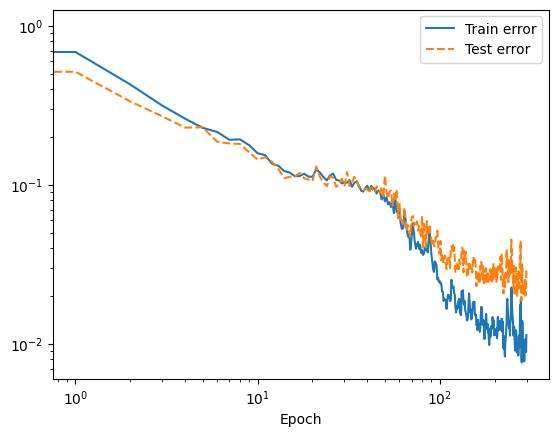

In [10]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

## Custom pulses

**NOTE**: The CVAE model was executed on GALADRIEL system and the predicted Dazzler coefficients were used. So here we don't take into account the backward prediction because could be different thant the one obtained that day and the ones calculated in my laptop.

In the experiment, 4 shots were executed for each custom shot

### Read dataset

In [11]:
#reference values
beta2=35000
beta3=0
beta4=-4.5e6

In [12]:
filename_pred='datasets/pulse_and_dazzler_250520b_pred.h5'

#read the Dazller input data
df_input_pred=pd.read_hdf(filename_pred,'df_input')

#read the reconstructed pulse data
df_time_200_pred=pd.read_hdf(filename_pred,'df_time_200')
df_pulse_200_pred=pd.read_hdf(filename_pred,'df_pulse_200')
t_200_pred=df_time_200_pred.to_numpy()

## Build prediction and plotting

In [13]:
def pred_cvae(model_cvae,y_ex_tensor,X_train,device):
    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    num_bins=100

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]
    
    return o2_pred, o3_pred, o4_pred

In [14]:
def pred_cust_cvae(y_ex_1,y_pred_1,df_input_pred_1,
                   y_ex_2,y_pred_2,df_input_pred_2,
                   y_ex_3,y_pred_3,df_input_pred_3,
                   model_cvae,forward_model_rf,
                   t_200,X_train,device,t_200_pred,
                   beta_ref_values):
    #prediction1
    y_ex_tensor=torch.tensor(y_ex_1,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
    o2_pred_1, o3_pred_1, o4_pred_1 = pred_cvae(model_cvae,y_ex_tensor,X_train,device)

    #prediction2
    y_ex_tensor=torch.tensor(y_ex_2,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
    o2_pred_2, o3_pred_2, o4_pred_2 = pred_cvae(model_cvae,y_ex_tensor,X_train,device)

    #prediction3
    y_ex_tensor=torch.tensor(y_ex_3,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))
    o2_pred_3, o3_pred_3, o4_pred_3 = pred_cvae(model_cvae,y_ex_tensor,X_train,device)

    #Forward prediction using CVAE backward prediction
    y_pred_fwd_cvae_1=forward_model_rf.predict(pd.DataFrame([(o2_pred_1,o3_pred_1,o4_pred_1)]))[0]
    y_pred_fwd_cvae_2=forward_model_rf.predict(pd.DataFrame([(o2_pred_2,o3_pred_2,o4_pred_2)]))[0]
    y_pred_fwd_cvae_3=forward_model_rf.predict(pd.DataFrame([(o2_pred_3,o3_pred_3,o4_pred_3)]))[0]

    #mae_cvae=abs(y_pred-y_pred_fwd_cvae)
    #mae_cvae=mae_cvae.sum()/len(y_pred)

    #print('PREDICTIONS (in my laptop):')
    #print('*CVAE:')
    #print(' -Order2:',o2_pred)
    #print(' -Order3:',o3_pred)
    #print(' -Order4:',o4_pred)

    shot_numb_1=int(df_input_pred_1["shot number"])#get_shot_num(shot_index,y_test,df_input)
    shot_numb_2=int(df_input_pred_2["shot number"])#get_shot_num(shot_index,y_test,df_input)
    shot_numb_3=int(df_input_pred_3["shot number"])#get_shot_num(shot_index,y_test,df_input)

    order2_1="{:.1e}".format(df_input_pred_1["order2"]-beta_ref_values[0])#get teh value and convert to str with 1value after .
    order3_1="{:.1e}".format(df_input_pred_1["order3"]-beta_ref_values[1])
    order4_1="{:.1e}".format(df_input_pred_1["order4"]-beta_ref_values[2])

    order2_2="{:.1e}".format(df_input_pred_2["order2"]-beta_ref_values[0])#get teh value and convert to str with 1value after .
    order3_2="{:.1e}".format(df_input_pred_2["order3"]-beta_ref_values[1])
    order4_2="{:.1e}".format(df_input_pred_2["order4"]-beta_ref_values[2])

    order2_3="{:.1e}".format(df_input_pred_3["order2"]-beta_ref_values[0])#get teh value and convert to str with 1value after .
    order3_3="{:.1e}".format(df_input_pred_3["order3"]-beta_ref_values[1])
    order4_3="{:.1e}".format(df_input_pred_3["order4"]-beta_ref_values[2])

    #calculate the MAE of the custom shot vs experimental shot
    mae_exp_1=abs(y_ex_1[:,0]-y_pred_1)
    mae_exp_1=mae_exp_1.sum()/len(y_ex_1)
    mae_exp_2=abs(y_ex_2[:,0]-y_pred_2)
    mae_exp_2=mae_exp_2.sum()/len(y_ex_2)
    mae_exp_3=abs(y_ex_3[:,0]-y_pred_3)
    mae_exp_3=mae_exp_3.sum()/len(y_ex_3)

    #define x limits for the 3 plots
    limit_min_x=-120
    limit_max_x=120

    ax1=plt.subplot(1,3,1)
    plt.plot(t_200,y_ex_1,label='Custom shot',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae_1,label='CVAE prediction',linewidth=3,color='tab:orange')
    plt.plot(t_200_pred,y_pred_1,label='Real shot (#'+str(shot_numb_1)+')',linewidth=3,color='tab:green')
    plt.legend()
    plt.ylabel('Intensity',fontsize=14)
    plt.text(-100, 0.15, r'(a)', dict(size=14))
    plt.text(-110, 0.90, r'$\delta\beta_2=$'+order2_1, dict(size=10))
    plt.text(-110, 0.80, r'$\delta\beta_3=$'+order3_1, dict(size=10))
    plt.text(-110, 0.70, r'$\delta\beta_4=$'+order4_1, dict(size=10))
    plt.text(30, 0.90, r'$MAE={:.1f}$%'.format(100*mae_exp_1), dict(size=10))
    plt.xlim([limit_min_x, limit_max_x])
    plt.xlabel('Time(fs)',fontsize=14)
    

    ax2=plt.subplot(1,3,2)
    plt.title('Custom shots: prediction and result',fontsize=14)
    plt.plot(t_200,y_ex_2,linestyle='--',linewidth=3,color='tab:blue') #label='Custom shot',
    plt.plot(t_200,y_pred_fwd_cvae_2,linewidth=3,color='tab:orange') #,label='CVAE prediction'
    plt.plot(t_200_pred,y_pred_2,label='Real shot (#'+str(shot_numb_2)+')',linewidth=3,color='tab:green')
    plt.legend()
    plt.text(-100, 0.15, r'(b)', dict(size=14))
    plt.text(-110, 0.90, r'$\delta\beta_2=$'+order2_2, dict(size=10))
    plt.text(-110, 0.80, r'$\delta\beta_3=$'+order3_2, dict(size=10))
    plt.text(-110, 0.70, r'$\delta\beta_4=$'+order4_2, dict(size=10))
    plt.text(30, 0.90, r'$MAE={:.1f}$%'.format(100*mae_exp_2), dict(size=10))
    plt.xlim([limit_min_x, limit_max_x])
    plt.xlabel('Time(fs)',fontsize=14)
    ax2.set_yticklabels([])

    ax3=plt.subplot(1,3,3)
    plt.plot(t_200,y_ex_3,linestyle='--',linewidth=3,color='tab:blue') #label='Custom shot'
    plt.plot(t_200,y_pred_fwd_cvae_3,linewidth=3,color='tab:orange') #,label='CVAE prediction'
    plt.plot(t_200_pred,y_pred_3,label='Real shot (#'+str(shot_numb_3)+')',linewidth=3,color='tab:green')
    plt.text(-100, 0.15, r'(c)', dict(size=14))
    plt.text(-110, 0.90, r'$\delta\beta_2=$'+order2_3, dict(size=10))
    plt.text(-110, 0.80, r'$\delta\beta_3=$'+order3_3, dict(size=10))
    plt.text(-110, 0.70, r'$\delta\beta_4=$'+order4_3, dict(size=10))
    plt.text(30, 0.90, r'$MAE={:.1f}$%'.format(100*mae_exp_3), dict(size=10))
    plt.xlim([limit_min_x, limit_max_x])
    ax3.set_yticklabels([])
   
    
    #plt.text(45, 0.65, r'$\beta_2=$'+order2, dict(size=14))
    #plt.text(45, 0.55, r'$\beta_3=$'+order3, dict(size=14))
    #plt.text(45, 0.45, r'$\beta_4=$'+order4, dict(size=14))
    #plt.text(-120,0.6,r'$MAE_{{pred}}={:.1f}$%'.format(100*mae_cvae))
    #plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    #plt.ylabel('Intensity',fontsize=14)
    plt.legend()
    #change the size of the figure
    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    fig.tight_layout()
    # Save figure in EPS format
    #plt.savefig('cust_shot.eps', format='eps', dpi=300, bbox_inches='tight')
    #plt.show()

In [15]:
#define the curve to fit (the custom pulse shape)
# It's just 5 gaussians
def func(t,a0, a1,a2,
        b0,b1,b2,
        c0,c1,c2,
        d0,d1,d2,
        e0,e1,e2): 
    #envelope=1*np.exp(-((t-0)**2)/(2*30*30))
    return (a0*np.exp(-((t-a1)**2)/(2*a2*a2))
            +b0*np.exp(-((t-b1)**2)/(2*b2*b2))
           +c0*np.exp(-((t-c1)**2)/(2*c2*c2))
           +d0*np.exp(-((t-d1)**2)/(2*d2*d2))
           +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))

In [16]:
beta_ref_values=[beta2,beta3,beta4] 

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


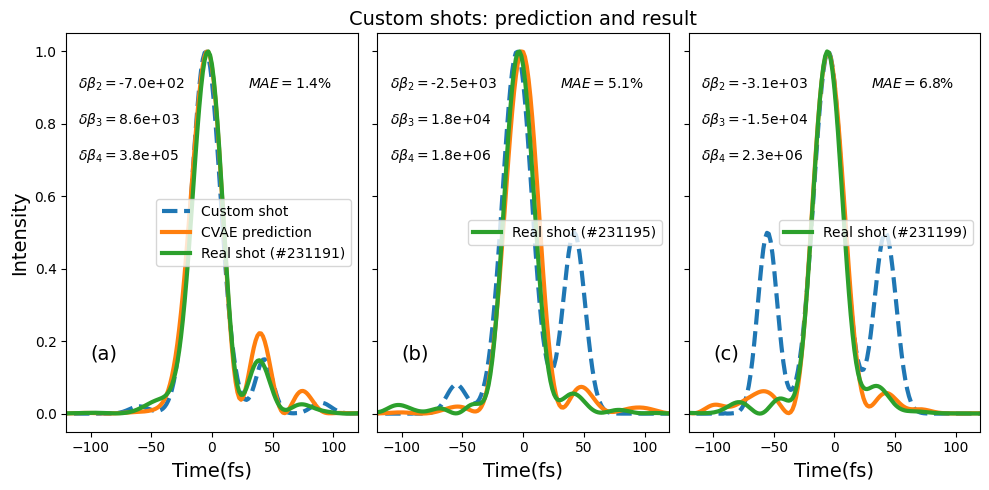

In [17]:
#FIRST SHOT
y_cust_shot_1=func(t_200,
                 0.001,-90,0.1,
                 0.02,-60,8,
                 1,-5,12,
                 0.15,+43,7,
                 0.03,+90,8)

pred_shot_index_1=0
y_pred_1=df_pulse_200_pred.iloc[pred_shot_index_1]
meta_pred_1=df_input_pred.iloc[pred_shot_index_1]

#SECOND SHOT
y_cust_shot_2=func(t_200,
                 0.001,-90,0.1,
                 0.08,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_shot_index_2=4
y_pred_2=df_pulse_200_pred.iloc[pred_shot_index_2]
meta_pred_2=df_input_pred.iloc[pred_shot_index_2]

#THIRD SHOT
y_cust_shot_3=func(t_200,
                 0.001,-90,0.1,
                 0.5,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_shot_index_3=8
y_pred_3=df_pulse_200_pred.iloc[pred_shot_index_3]
meta_pred_3=df_input_pred.iloc[pred_shot_index_3]

pred_cust_cvae(y_cust_shot_1,y_pred_1,meta_pred_1,
               y_cust_shot_2,y_pred_2,meta_pred_2,
               y_cust_shot_3,y_pred_3,meta_pred_3,
               model_cvae,forward_model_rf,
               t_200,X_train,device,t_200_pred,
               beta_ref_values)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


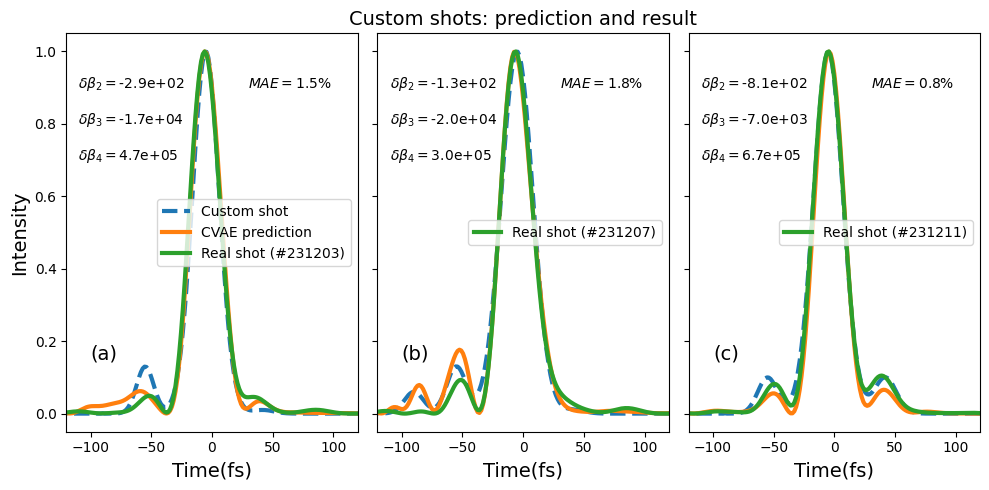

In [18]:
#FOURTH SHOT
y_cust_shot_4=func(t_200,
                 0.001,-90,0.1,
                 0.13,-55,7,
                 1,-5,11,
                 0.01,+42,9,
                 0.00,+90,8)

pred_shot_index_4=12
y_pred_4=df_pulse_200_pred.iloc[pred_shot_index_4]
meta_pred_4=df_input_pred.iloc[pred_shot_index_4]

#FIFTH SHOT
y_cust_shot_5=func(t_200,
                 0.06,-90,8,
                 0.13,-55,8,
                 1,-5,13,
                 0.01,+42,9,
                 0.00,+90,8)

pred_shot_index_5=16
y_pred_5=df_pulse_200_pred.iloc[pred_shot_index_5]
meta_pred_5=df_input_pred.iloc[pred_shot_index_5]

#SIXTH SHOT
y_cust_shot_6=func(t_200,
                 0.001,-90,0.1,
                 0.1,-55,8,
                 1,-5,12,
                 0.10,+42,9,
                 0.00,+90,8)

pred_shot_index_6=20
y_pred_6=df_pulse_200_pred.iloc[pred_shot_index_6]
meta_pred_6=df_input_pred.iloc[pred_shot_index_6]

pred_cust_cvae(y_cust_shot_4,y_pred_4,meta_pred_4,
               y_cust_shot_5,y_pred_5,meta_pred_5,
               y_cust_shot_6,y_pred_6,meta_pred_6,
               model_cvae,forward_model_rf,
               t_200,X_train,device,t_200_pred,
               beta_ref_values)